In [33]:
from prophet import Prophet
import pandas as pd
import numpy as np
import os
import pickle
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
TOP_X_CRIMES = 10 

In [35]:
path = '..\\data\\mergedData\\ts_df.csv'
ts_df = pd.read_csv(path)
ts_df = ts_df.loc[:, ~ts_df.columns.str.contains('^Unnamed')]
ts_df.head()

,Reported_Date,dist_id,Offense_Cluster,Cluster_Name,Cluster_Description,lon,lat,Month
0,2015-03-06,6.0,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w...",-94.5767,38.9767,2015-03
1,2015-09-08,3.0,26,Auto Theft,"Incidents involving auto theft, theft, and aut...",-94.5516,39.0947,2015-09
2,2015-05-19,3.0,14,Possession Sale,"Incidents involving possession sale, distribut...",-94.5461,39.0735,2015-05
3,2015-08-31,1.0,20,Assault,"Incidents involving non-aggravated assault, ag...",-89.0251,42.2167,2015-08
4,2015-12-04,3.0,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w...",-94.5645,39.0952,2015-12


In [36]:
dist_ids = ts_df.dist_id.unique()
dist_ids = sorted(dist_ids)
print("dist_ids", dist_ids)
num_dists = len(dist_ids)
print("num_dists", num_dists)

dist_ids [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
num_dists 6


In [37]:
cluster_names = ts_df.Cluster_Name.unique()
cluster_names = sorted(cluster_names)
print("cluster_names", cluster_names)
num_cluster_names = len(cluster_names)
print("num_cluster_names", num_cluster_names)

cluster_names ['Aggravated Assault', 'Alcohol Influence', 'Armed Robbery', 'Arson', 'Assault', 'Auto Accessory Theft', 'Auto Parts Theft', 'Auto Theft', 'Building Theft', 'Burglary', 'Child Abuse', 'Credit Debit', 'Dead Body', 'Disorderly Conduct', 'Distribution Controlled Substance', 'Domestic Assault', 'Domestic Burglary', 'Domestic Violence', 'Domestic Violence Property', 'Driving Influence', 'Eluding Resisting', 'Embezzlement', 'Ex Parte', 'Family Offense', 'Felon Prohibited Person Possession Firearm', 'Forgery', 'Fraud', 'Fraudulent Use Credit', 'Hit Run', 'Identity Theft', 'Impersonation', 'Intimidation', 'Investigation', 'Miscellaneous Violation', 'Municipal Warrant Arrest', 'Murder', 'Possession Drug', 'Possession Sale', 'Property Damage', 'Rape', 'Recovered Stolen', 'Resisting Officer', 'Robbery', 'Scam', 'Sexual Assault', 'Sexual Misconduct', 'Shoplifting', 'Sodomy', 'Stolen Auto', 'Stolen Property', 'Strong Arm Robbery', 'Terroristic Threats', 'Theft', 'Trespassing', 'Vehicu

In [ ]:
crime_dist_dfs = {}
for i, dist_id in enumerate(dist_ids):
    # Filter data for this district
    dist_data = ts_df[ts_df['dist_id'] == dist_id]
    crime_dist_dfs[dist_id] = {}
    for i, cluster_name in enumerate(cluster_names):
        crime_data = dist_data[dist_data['Cluster_Name'] == cluster_name]
        # Prepare ts data and split
        train = crime_data.loc[crime_data.Reported_Date < "2024-01-01"]
        test = crime_data.loc[crime_data.Reported_Date >= "2024-01-01"]

        train = train.groupby("Reported_Date").size().reset_index(name='Crime_Count')
        test = test.groupby("Reported_Date").size().reset_index(name='Crime_Count')

        # Ensure 'Reported_Date' is datetime
        train['Reported_Date'] = pd.to_datetime(train['Reported_Date'])
        test['Reported_Date'] = pd.to_datetime(test['Reported_Date'])

        # Set 'Reported_Date' as index and reindex to daily frequency
        train = train.set_index('Reported_Date').asfreq('d', fill_value=0)
        test = test.set_index('Reported_Date').asfreq('d', fill_value=0)

        # Save final dict
        crime_dist_dfs[dist_id][cluster_name] = {
            "train": train,
            "test": test
        }

In [39]:
print(f"number of datasets in dict: {num_dists*num_cluster_names}")
print(f"districts in dict: {crime_dist_dfs.keys()}")
print(f"crimes in dict: {crime_dist_dfs[1.0].keys()}")
print(f"test/train in dict: {crime_dist_dfs[1.0]['Alcohol Influence'].keys()}")

number of datasets in dict: 354
districts in dict: dict_keys([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
crimes in dict: dict_keys(['Aggravated Assault', 'Alcohol Influence', 'Armed Robbery', 'Arson', 'Assault', 'Auto Accessory Theft', 'Auto Parts Theft', 'Auto Theft', 'Building Theft', 'Burglary', 'Child Abuse', 'Credit Debit', 'Dead Body', 'Disorderly Conduct', 'Distribution Controlled Substance', 'Domestic Assault', 'Domestic Burglary', 'Domestic Violence', 'Domestic Violence Property', 'Driving Influence', 'Eluding Resisting', 'Embezzlement', 'Ex Parte', 'Family Offense', 'Felon Prohibited Person Possession Firearm', 'Forgery', 'Fraud', 'Fraudulent Use Credit', 'Hit Run', 'Identity Theft', 'Impersonation', 'Intimidation', 'Investigation', 'Miscellaneous Violation', 'Municipal Warrant Arrest', 'Murder', 'Possession Drug', 'Possession Sale', 'Property Damage', 'Rape', 'Recovered Stolen', 'Resisting Officer', 'Robbery', 'Scam', 'Sexual Assault', 'Sexual Misconduct', 'Shoplifting', 'Sodomy', 'Stol

In [40]:
crime_dist_dfs[1.0]['Alcohol Influence']["train"].head()

,Crime_Count
Reported_Date,
2019-04-09,1
2019-04-10,0
2019-04-11,0
2019-04-12,0
2019-04-13,0


In [41]:
def get_top_x_crimes(crime_dist_dfs, X = 10):
    # Step 1: Aggregate crime counts across dates and districts
    total_crime_counts = defaultdict(int)

    for district, crimes in crime_dist_dfs.items():
        for crime, data_dict in crimes.items():
            # Sum the Crime_Count column for the 'train' DataFrame of each crime
            total_crime_counts[crime] += data_dict["train"]["Crime_Count"].sum()

    # Step 2: Sort crimes by count in descending order and extract the top X crimes
    top_crimes_set = sorted(total_crime_counts.items(), key=lambda x: x[1], reverse=True)[:X]

    top_crimes = []
    # Display the top X crimes
    for crime, count in top_crimes_set:
        print(f"{crime}: {count}")
        top_crimes.append(crime)

    # Step 3: Filter `crime_dist_dfs` to retain only the top X crimes
    filtered_crime_dist_dfs = {
        district: {crime: data_dict for crime, data_dict in crimes.items() if crime in top_crimes}
        for district, crimes in crime_dist_dfs.items()
    }

    # `filtered_crime_dist_dfs` now contains only the top X crimes
    return filtered_crime_dist_dfs

In [42]:
crime_dist_dfs = get_top_x_crimes(crime_dist_dfs, X = TOP_X_CRIMES)

Auto Theft: 97053
Property Damage: 71590
Burglary: 61688
Domestic Assault: 58957
Aggravated Assault: 50526
Assault: 46546
Shoplifting: 46063
Sexual Assault: 41548
Domestic Violence: 35351
Stolen Auto: 35063


In [ ]:
# Loop through each district and crime category
for dist_id, crimes in crime_dist_dfs.items():
    for cluster_name, data_splits in tqdm.tqdm(crimes.items(), desc=f"Processing District {dist_id}", leave=False):
        train = data_splits["train"]
        test = data_splits["test"]

        try:
            # Prepare data for Prophet
            train_data_prepared = train.reset_index().rename(columns={'Reported_Date': 'ds', 'Crime_Count': 'y'})
            test_data_prepared = test.reset_index().rename(columns={'Reported_Date': 'ds', 'Crime_Count': 'y'})

            # Ensure 'ds' is datetime
            train_data_prepared['ds'] = pd.to_datetime(train_data_prepared['ds'])
            test_data_prepared['ds'] = pd.to_datetime(test_data_prepared['ds'])

            # Check for NaNs in train_data_prepared
            if train_data_prepared.isnull().values.any():
                print(f"NaN values found in training data for district {dist_id}, crime {cluster_name}")
                print(train_data_prepared[train_data_prepared.isnull().any(axis=1)])
                crime_dist_dfs[dist_id][cluster_name]["model_config"] = None
                continue  # Skip to the next crime

            # Check if training data is empty
            if train_data_prepared.empty:
                print(f"Training data is empty for district {dist_id}, crime {cluster_name}. Skipping.")
                crime_dist_dfs[dist_id][cluster_name]["model_config"] = None
                continue  # Skip to the next crime

            # Fit Prophet model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
            model.fit(train_data_prepared)

            # Determine the number of predictions
            n_predictions = len(test_data_prepared) if len(test_data_prepared) > 0 else 265

            # Create future dataframe
            future_dates = model.make_future_dataframe(periods=n_predictions, freq='D')
            forecast = model.predict(future_dates)

            # Extract the predicted values
            predicted_values = forecast[['ds', 'yhat']]

            # If test data is available, calculate RMSE
            if len(test_data_prepared) > 0:
                # Merge test_data and predicted_values on 'ds'
                merged = test_data_prepared.merge(predicted_values, on='ds', how='left')
                rmse = sqrt(mean_squared_error(merged['y'], merged['yhat']))
                crime_dist_dfs[dist_id][cluster_name]["model_config"] = {"rmse": rmse}
            else:
                crime_dist_dfs[dist_id][cluster_name]["model_config"] = {"rmse": None}

            # Save forecast and residuals
            crime_dist_dfs[dist_id][cluster_name]["forecast"] = forecast
            residuals = train_data_prepared['y'] - model.predict(train_data_prepared)['yhat']
            crime_dist_dfs[dist_id][cluster_name]["residuals"] = residuals

        except Exception as e:
            print(f"Prophet model failed for district {dist_id}, crime {cluster_name} with error: {e}")
            crime_dist_dfs[dist_id][cluster_name]["model_config"] = None


Processing District 1.0:   0%|          | 0/10 [00:00<?, ?it/s]23:29:19 - cmdstanpy - INFO - Chain [1] start processing
23:29:19 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]23:29:20 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Aggravated Assault with error: Input contains NaN.


23:29:20 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  20%|██        | 2/10 [00:01<00:07,  1.14it/s]23:29:21 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Assault with error: Input contains NaN.


23:29:21 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  30%|███       | 3/10 [00:02<00:06,  1.12it/s]23:29:21 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Auto Theft with error: Input contains NaN.


23:29:22 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  40%|████      | 4/10 [00:03<00:05,  1.15it/s]23:29:22 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Burglary with error: Input contains NaN.


23:29:22 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  50%|█████     | 5/10 [00:04<00:04,  1.16it/s]23:29:23 - cmdstanpy - INFO - Chain [1] start processing
23:29:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 1.0, crime Domestic Assault with error: Input contains NaN.


Processing District 1.0:  60%|██████    | 6/10 [00:04<00:02,  1.38it/s]23:29:24 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Domestic Violence with error: Input contains NaN.


23:29:24 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  70%|███████   | 7/10 [00:05<00:02,  1.23it/s]23:29:25 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Property Damage with error: Input contains NaN.


23:29:25 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  80%|████████  | 8/10 [00:06<00:01,  1.23it/s]23:29:25 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 1.0, crime Sexual Assault with error: Input contains NaN.


23:29:26 - cmdstanpy - INFO - Chain [1] done processing
Processing District 1.0:  90%|█████████ | 9/10 [00:08<00:01,  1.04s/it]23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:   0%|          | 0/10 [00:00<?, ?it/s]         23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:28 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]23:29:28 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 2.0, crime Aggravated Assault with error: Input contains NaN.


23:29:29 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  20%|██        | 2/10 [00:01<00:06,  1.17it/s]23:29:29 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 2.0, crime Assault with error: Input contains NaN.


23:29:30 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  30%|███       | 3/10 [00:02<00:05,  1.19it/s]23:29:30 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 2.0, crime Auto Theft with error: Input contains NaN.


23:29:30 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  40%|████      | 4/10 [00:03<00:04,  1.22it/s]23:29:31 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 2.0, crime Burglary with error: Input contains NaN.


23:29:31 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  50%|█████     | 5/10 [00:04<00:04,  1.18it/s]23:29:32 - cmdstanpy - INFO - Chain [1] start processing
23:29:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 2.0, crime Domestic Assault with error: Input contains NaN.


Processing District 2.0:  60%|██████    | 6/10 [00:04<00:03,  1.26it/s]23:29:33 - cmdstanpy - INFO - Chain [1] start processing
23:29:33 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  70%|███████   | 7/10 [00:05<00:02,  1.22it/s]23:29:33 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 2.0, crime Property Damage with error: Input contains NaN.


23:29:34 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  80%|████████  | 8/10 [00:06<00:01,  1.21it/s]23:29:34 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 2.0, crime Sexual Assault with error: Input contains NaN.


23:29:34 - cmdstanpy - INFO - Chain [1] done processing
Processing District 2.0:  90%|█████████ | 9/10 [00:07<00:00,  1.22it/s]23:29:35 - cmdstanpy - INFO - Chain [1] start processing
23:29:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 2.0, crime Shoplifting with error: Input contains NaN.


Prophet model failed for district 2.0, crime Stolen Auto with error: Input contains NaN.


Processing District 3.0:   0%|          | 0/10 [00:00<?, ?it/s]23:29:36 - cmdstanpy - INFO - Chain [1] start processing
23:29:36 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  10%|█         | 1/10 [00:01<00:11,  1.28s/it]23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  20%|██        | 2/10 [00:02<00:10,  1.34s/it]23:29:38 - cmdstanpy - INFO - Chain [1] start processing
23:29:38 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]23:29:40 - cmdstanpy - INFO - Chain [1] start processing
23:29:40 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  40%|████      | 4/10 [00:04<00:07,  1.17s/it]23:29:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 3.0, crime Burglary with error: Input contains NaN.


23:29:41 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  50%|█████     | 5/10 [00:05<00:05,  1.07s/it]23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 3.0, crime Domestic Assault with error: Input contains NaN.


Processing District 3.0:  60%|██████    | 6/10 [00:06<00:03,  1.08it/s]23:29:42 - cmdstanpy - INFO - Chain [1] start processing
23:29:42 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  70%|███████   | 7/10 [00:07<00:02,  1.10it/s]23:29:43 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 3.0, crime Property Damage with error: Input contains NaN.


23:29:43 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  80%|████████  | 8/10 [00:08<00:02,  1.06s/it]23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:45 - cmdstanpy - INFO - Chain [1] done processing
Processing District 3.0:  90%|█████████ | 9/10 [00:09<00:01,  1.02s/it]23:29:45 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 3.0, crime Shoplifting with error: Input contains NaN.


23:29:45 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:   0%|          | 0/10 [00:00<?, ?it/s]         23:29:46 - cmdstanpy - INFO - Chain [1] start processing
23:29:46 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]23:29:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 4.0, crime Aggravated Assault with error: Input contains NaN.


23:29:47 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  20%|██        | 2/10 [00:02<00:08,  1.12s/it]23:29:48 - cmdstanpy - INFO - Chain [1] start processing
23:29:49 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  30%|███       | 3/10 [00:03<00:09,  1.33s/it]23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  40%|████      | 4/10 [00:05<00:07,  1.32s/it]23:29:51 - cmdstanpy - INFO - Chain [1] start processing
23:29:51 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  50%|█████     | 5/10 [00:05<00:05,  1.15s/it]23:29:52 - cmdstanpy - INFO - Chain [1] start processing
23:29:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 4.0, crime Domestic Assault with error: Input contains NaN.


Processing District 4.0:  60%|██████    | 6/10 [00:06<00:03,  1.00it/s]23:29:53 - cmdstanpy - INFO - Chain [1] start processing
23:29:53 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  70%|███████   | 7/10 [00:07<00:03,  1.13s/it]23:29:54 - cmdstanpy - INFO - Chain [1] start processing
23:29:54 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  80%|████████  | 8/10 [00:09<00:02,  1.19s/it]23:29:55 - cmdstanpy - INFO - Chain [1] start processing
23:29:56 - cmdstanpy - INFO - Chain [1] done processing
Processing District 4.0:  90%|█████████ | 9/10 [00:10<00:01,  1.27s/it]23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:   0%|          | 0/10 [00:00<?, ?it/s]         23:29:58 - cmdstanpy - INFO - Chain [1] start processing
23:29:58 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  10%|█         | 1/10 [00:01<00:12,  1.41s/it]23:29:59

Prophet model failed for district 5.0, crime Assault with error: Input contains NaN.


23:30:00 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  30%|███       | 3/10 [00:03<00:09,  1.30s/it]23:30:02 - cmdstanpy - INFO - Chain [1] start processing
23:30:02 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  40%|████      | 4/10 [00:04<00:07,  1.17s/it]23:30:02 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 5.0, crime Burglary with error: Input contains NaN.


23:30:03 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  50%|█████     | 5/10 [00:06<00:06,  1.30s/it]23:30:04 - cmdstanpy - INFO - Chain [1] start processing
23:30:04 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  60%|██████    | 6/10 [00:07<00:04,  1.10s/it]23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  70%|███████   | 7/10 [00:08<00:03,  1.22s/it]23:30:06 - cmdstanpy - INFO - Chain [1] start processing
23:30:06 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  80%|████████  | 8/10 [00:09<00:02,  1.28s/it]23:30:08 - cmdstanpy - INFO - Chain [1] start processing
23:30:08 - cmdstanpy - INFO - Chain [1] done processing
Processing District 5.0:  90%|█████████ | 9/10 [00:10<00:01,  1.15s/it]23:30:08 - cmdstanpy - INFO - Chain [1] start processing
23:30:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 5.0, crime Shoplifting with error: Input contains NaN.


Processing District 6.0:   0%|          | 0/10 [00:00<?, ?it/s]         23:30:09 - cmdstanpy - INFO - Chain [1] start processing
23:30:09 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  10%|█         | 1/10 [00:00<00:07,  1.17it/s]23:30:10 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 6.0, crime Aggravated Assault with error: Input contains NaN.


23:30:10 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  20%|██        | 2/10 [00:01<00:07,  1.12it/s]23:30:11 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 6.0, crime Assault with error: Input contains NaN.


23:30:11 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  30%|███       | 3/10 [00:02<00:06,  1.07it/s]23:30:12 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 6.0, crime Auto Theft with error: Input contains NaN.


23:30:12 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  40%|████      | 4/10 [00:03<00:05,  1.06it/s]23:30:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 6.0, crime Burglary with error: Input contains NaN.


23:30:13 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  50%|█████     | 5/10 [00:04<00:04,  1.05it/s]23:30:14 - cmdstanpy - INFO - Chain [1] start processing
23:30:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet model failed for district 6.0, crime Domestic Assault with error: Input contains NaN.


Processing District 6.0:  60%|██████    | 6/10 [00:05<00:03,  1.17it/s]23:30:15 - cmdstanpy - INFO - Chain [1] start processing
23:30:15 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  70%|███████   | 7/10 [00:06<00:02,  1.15it/s]23:30:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet model failed for district 6.0, crime Property Damage with error: Input contains NaN.


23:30:16 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  80%|████████  | 8/10 [00:07<00:02,  1.02s/it]23:30:17 - cmdstanpy - INFO - Chain [1] start processing
23:30:17 - cmdstanpy - INFO - Chain [1] done processing
Processing District 6.0:  90%|█████████ | 9/10 [00:09<00:01,  1.15s/it]23:30:18 - cmdstanpy - INFO - Chain [1] start processing
23:30:18 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
def plot_crime_forecast(train_data, test_data, forecast_data, crime_type="Unknown Crime", district_id="Unknown District"):
    plt.figure(figsize=(20, 6))

    # Plot training data
    plt.plot(train_data['ds'], train_data['y'], label="Training Data", color="blue")

    # Plot test data
    if len(test_data) > 0:
        plt.plot(test_data['ds'], test_data['y'], label="Test Data (Actual)", color="green")

    # Plot forecast data
    plt.plot(forecast_data['ds'], forecast_data['yhat'], label="Predictions", color="red", linestyle="--")

    # Formatting the plot
    plt.title(f"Crime Forecast for {crime_type} in District {district_id}")
    plt.xlabel("Date")
    plt.ylabel("Number of Crimes")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

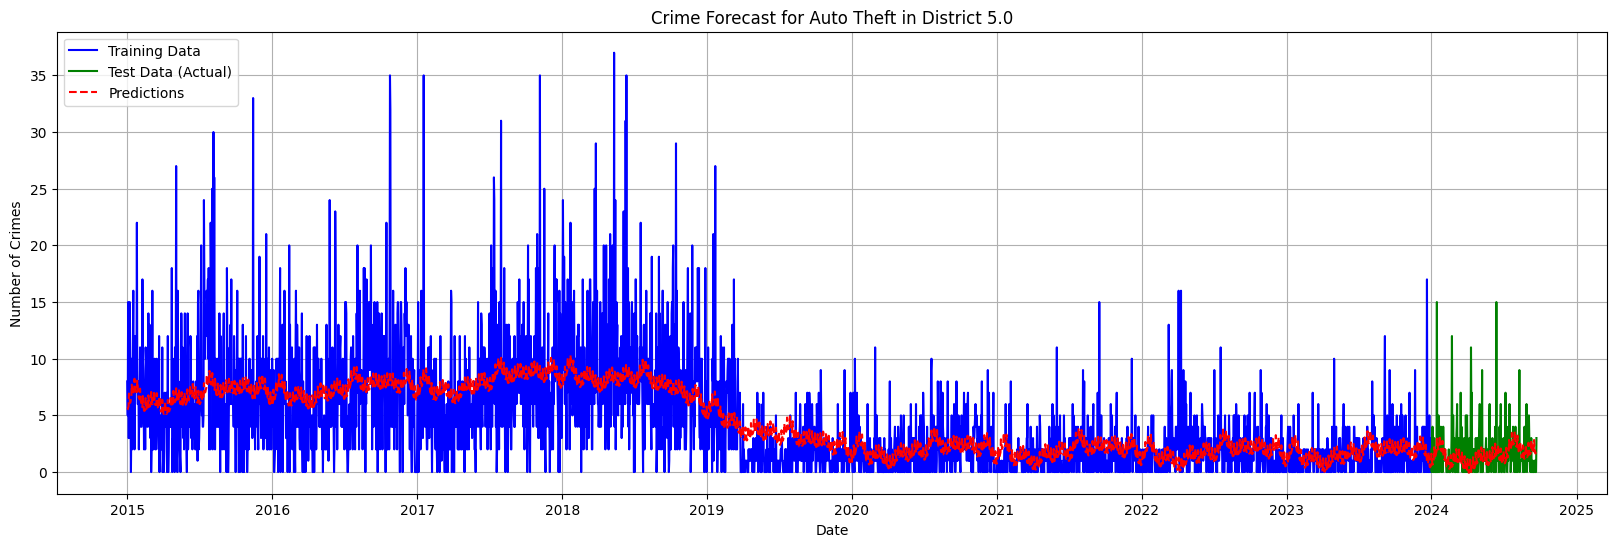

In [45]:
district = 5.0
crime_name = 'Auto Theft'

# Prepare data for plotting
train_data = crime_dist_dfs[district][crime_name]["train"].reset_index().rename(columns={'Reported_Date': 'ds', 'Crime_Count': 'y'})
test_data = crime_dist_dfs[district][crime_name]["test"].reset_index().rename(columns={'Reported_Date': 'ds', 'Crime_Count': 'y'})
forecast_data = crime_dist_dfs[district][crime_name]["forecast"]

plot_crime_forecast(train_data, test_data, forecast_data, crime_type=crime_name, district_id=district)


In [48]:
def plot_rmse_heatmap(crime_dist_dfs):
    """
    Function to create a heatmap plot of RMSE values for crimes across districts
    """
    # Initialize an empty dictionary to hold RMSE values
    rmse_data = {
        "District": [],
        "Crime": [],
        "RMSE": []
    }
    
    # Collect RMSE values for each crime in each district
    for dist_id, crimes in crime_dist_dfs.items():
        for crime_name, crime_info in crimes.items():
            if crime_info.get("model_config") and crime_info["model_config"].get("rmse") is not None:
                rmse_data["District"].append(dist_id)
                rmse_data["Crime"].append(crime_name)
                rmse_data["RMSE"].append(crime_info["model_config"]["rmse"])
    
    # Create a DataFrame from the collected RMSE data
    rmse_df = pd.DataFrame(rmse_data)
    rmse_pivot = rmse_df.pivot(index="Crime", columns="District", values="RMSE")
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(rmse_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
    plt.title("RMSE of Crime Predictions by District and Crime Category")
    plt.xlabel("District")
    plt.ylabel("Crime Category")
    plt.tight_layout()
    plt.show()



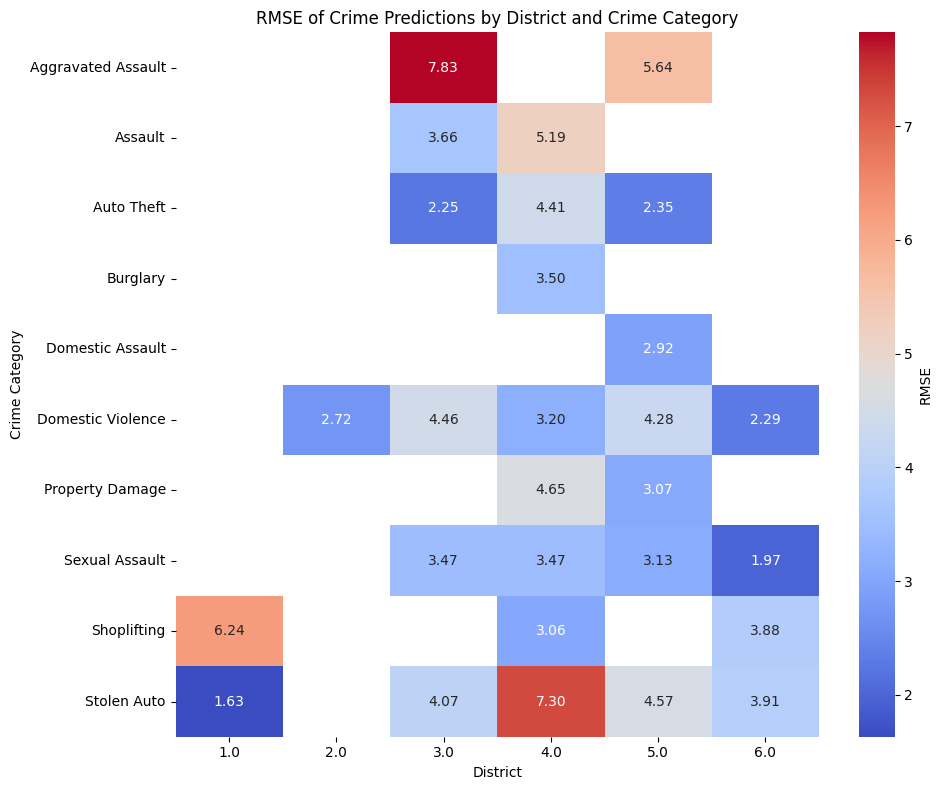

In [49]:
plot_rmse_heatmap(crime_dist_dfs)

In [ ]:
with open(f"..\\data\\mergedData\\crime_dist_dfs_prophet_top_{TOP_X_CRIMES}.pkl", 'wb') as file:
    pickle.dump(crime_dist_dfs, file)
